In [ ]:
import numpy as np
import pandas as pd
from numpy import newaxis

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from statsmodels.tsa import stattools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!nvidia-smi

Sun Jun 12 13:45:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    38W / 250W |  16259MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import torch
import random
import warnings
import numpy as np
import json
from logging import warning

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def try_gpu(i=0):
    gpu_count = torch.cuda.device_count()
    if gpu_count > 0:
        if gpu_count >= i + 1:
            return torch.device(f'cuda:{i}')
        else:
            warnings.warn("There are no enough devices, use the cuda:0 instead.")
            return torch.device(f'cuda:{0}')
    return torch.device('cpu')

def get_all_gpus() -> list:
    '''
    :return: list
    '''
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [ ]:
filename = '/content/drive/MyDrive/ICU/complete_data.csv'
data_icu = pd.read_csv(filename).copy()

In [ ]:
data_icu

,icustay_id,tw_hour_idx,bpd,bpm,bps,albumin,alt,arterial_ph,phosphorous,alkaline_phosphate,...,cardiovascular_points,respiration_points,bilirubin_points,creatinine_points,urine_points,platelets_points,gcs_points,total_sofa_score,total_apacheii_score,total_sapsii_score
0,200001,1,65.0,76.500000,111.5,2.8,42.0,7.41,3.4,100.0,...,0,3,0,0,4,0,0,7,22,47
1,200001,2,68.0,79.000000,113.0,2.8,42.0,7.41,3.4,100.0,...,0,3,0,0,4,0,0,7,20,47
2,200001,3,68.0,79.000000,116.0,2.8,42.0,7.41,3.4,100.0,...,0,3,0,0,4,0,0,7,23,47
3,200001,4,61.0,71.000000,102.0,2.8,42.0,7.41,3.4,100.0,...,0,3,0,0,4,0,0,7,20,47
4,200001,5,58.0,69.000000,103.0,2.8,42.0,7.41,3.4,100.0,...,1,3,0,0,4,0,0,8,22,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021200,299999,27,42.0,62.666698,104.0,2.8,42.0,7.38,3.4,100.0,...,1,2,0,0,4,0,0,7,12,38
5021201,299999,28,50.0,68.333298,105.0,2.8,42.0,7.38,3.4,100.0,...,1,2,0,0,4,0,0,7,12,38
5021202,299999,29,48.0,66.666702,104.0,2.8,42.0,7.38,3.4,100.0,...,1,2,0,0,4,0,0,7,11,38
5021203,299999,30,49.0,67.666702,105.0,2.8,42.0,7.38,3.4,100.0,...,1,2,0,0,4,0,0,7,11,38


In [ ]:
def MyData(data, hrs, label):
    """
    Return x_train, y_train, and other data for the seq2seq model.
    Meanwhile, MinMax each data.
    """
    
    icu_stays_ids = data.iloc[0:, 0].values.copy()
    icu_stays_idx = {}

    for j in np.unique(icu_stays_ids):
        icu_stays_idx[j] = []

    for i in range(len(icu_stays_ids)):
        if i == len(icu_stays_ids) - 1:
            icu_stays_idx[icu_stays_ids[i]].append(i)
            break
        if icu_stays_ids[i] != icu_stays_ids[i + 1]:
            continue
        icu_stays_idx[icu_stays_ids[i]].append(i)

    i_list = []

    for i in icu_stays_idx.keys():
        if len(icu_stays_idx[i]) < hrs * 2:
            i_list.append(i)
        
    for j in i_list:
        icu_stays_idx.pop(j)

    x_train_ = []
    y_train_ = []
    encoder_input = []

    for i in icu_stays_idx.keys():
        icu_stay_label = []
        icu_stay_feature = []
        icu_encoder_input = []
        for j in range(hrs):
            icu_stay_feature.append(data.iloc[icu_stays_idx[i][j], 2:-3].values.copy())
            icu_encoder_input.append(data.iloc[icu_stays_idx[i][j], -3:-2].values.copy())
            icu_stay_label.append(data.iloc[icu_stays_idx[i][j + hrs], label])
        x_train_.append(icu_stay_feature)
        encoder_input.append(icu_encoder_input)
        y_train_.append(icu_stay_label)
    
    return np.array(x_train_), np.array(y_train_), np.array(encoder_input)

In [ ]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers,
                 output_size, batch_size, dropout, device):
        super().__init__() 
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers = hidden_layers

        self.rnn = torch.nn.GRU(input_size, hidden_layer_size, hidden_layers, dropout=dropout, batch_first=True)
        self.l1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
        self.l2 = torch.nn.Linear(hidden_layer_size, output_size)

        self.relu = torch.nn.ReLU()
        self.hidden_cell = torch.zeros(hidden_layers, batch_size, self.hidden_layer_size).to(device)

    def forward(self, input_seq):
        gru_out, self.hidden_cell = self.rnn(input_seq, self.hidden_cell)
        l1_out = self.l1(gru_out) 
        l1_out = self.relu(l1_out)
        predictions = self.l2(l1_out)
        
        return predictions[:, -1, :]

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers,
                 output_size, batch_size, dropout, device):
        super().__init__() 
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers = hidden_layers

        self.rnn = torch.nn.RNN(input_size, hidden_layer_size, hidden_layers, dropout=dropout, batch_first=True)
        self.l1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
        self.l2 = torch.nn.Linear(hidden_layer_size, output_size)

        self.relu = torch.nn.ReLU()
        self.hidden_cell = torch.zeros(hidden_layers, batch_size, self.hidden_layer_size).to(device)

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq, self.hidden_cell)
        l1_out = self.l1(rnn_out) 
        l1_out = self.relu(l1_out)
        predictions = self.l2(l1_out)
        
        return predictions[:, -1, :]

class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers,
                 output_size, batch_size, dropout, device):
        super().__init__() 
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers = hidden_layers

        self.rnn = torch.nn.LSTM(input_size, hidden_layer_size, hidden_layers, dropout=dropout, batch_first=True)
        self.l1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
        self.l2 = torch.nn.Linear(hidden_layer_size, output_size)

        self.relu = torch.nn.ReLU()
        self.hidden_cell = (torch.zeros(hidden_layers, batch_size, self.hidden_layer_size).to(device),
                            torch.zeros(hidden_layers, batch_size, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.rnn(input_seq, self.hidden_cell)
        l1_out = self.l1(lstm_out) 
        l1_out = self.relu(l1_out)
        predictions = self.fc2(l1_out)
        
        return predictions[:, -1, :]


In [ ]:
class MapeLoss(torch.nn.Module):
    def __init__(self):
        super(MapeLoss, self).__init__()
        return

    def forward(self, y_pred, y):
        return torch.mean((y - y_pred).abs() / torch.mean(torch.clip(y, 1e-6, 1).abs()))

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, y_pred, y):
        return torch.sqrt(self.mse(y_pred, y))

class RSLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        target_mean = torch.mean(y)
        ss_tot = torch.sum((y - target_mean) ** 2)
        ss_res = torch.sum((y - y_pred) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2

In [ ]:
mse_train = torch.nn.MSELoss()

mse_test = torch.nn.MSELoss()
mae_test = torch.nn.L1Loss()
mape_test = MapeLoss()
rmse_test = RMSELoss()
rs_test = RSLoss()

In [ ]:
from torch.utils import data
from torch.utils.data import Dataset

class myData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [ ]:
def train_sofa(learning_rate, weight_decay, dropout, seed, nn_model, duration):
    torch.cuda.empty_cache()
    device = try_gpu(0)

    x_train, x_val, y_train, y_val = train_test_split(E_train, Y_train, test_size=0.1, random_state=seed)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=seed)

    x_val = x_val.astype(float)
    x_train = torch.Tensor(x_train).to(device)
    y_train = torch.Tensor(y_train).to(device)
    x_val = torch.Tensor(x_val).to(device)
    y_val = torch.Tensor(y_val).to(device)

    data_train = myData(x_train, y_train)
    data_test = myData(x_val, y_val)

    if nn_model == 'rnn':
        model = RNN(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=hidden_layers,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
    elif nn_model == 'gru':
        model = GRU(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=3,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
    elif nn_model == 'lstm':
        model = LSTM(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=hidden_layers,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
        
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=10**(-learning_rate), weight_decay=5*10**(-weight_decay))

    trainloader = torch.utils.data.DataLoader(data_train,
                                            batch_size=128,
                                            shuffle=False,
                                            drop_last=True)
    
    testloader = torch.utils.data.DataLoader(data_test,
                                         batch_size=128,
                                         shuffle=False,
                                         drop_last=True)

    print(x_train.shape)
    print(y_train.shape)

    testing_mse_losses = []
    testing_mae_losses = []
    testing_mape_losses = []
    testing_rmse_losses = []

    training_losses = []

    for i in tqdm(range(num_epochs)):
        training_loss = []
        for (input_x, input_y) in trainloader:
            
            optimizer.zero_grad()
            model = model.train()
            if nn_model == 'lstm':
                model.hidden_cell = (torch.zeros(hidden_layers, batch_size,hidden_layer_size).to(device),
                                     torch.zeros(hidden_layers, batch_size,hidden_layer_size).to(device))
            else:
                model.hidden_cell = torch.zeros((hidden_layers, batch_size, hidden_layer_size), device=device)

            input_x = input_x.view(input_x.shape[0], duration, 1)
            input_x = input_x.to(device)
            output = model(input_x)
            single_loss = mse_train(output, input_y)
            single_loss.backward()

            optimizer.step()
            training_loss.append(single_loss.item())

        training_losses.append(np.mean(training_loss))

        with torch.no_grad():
            model.eval()
            model.to(device)

            test_mse_loss = []
            test_mae_loss = []
            test_mape_loss = []
            test_rmse_loss = []
            
            for (x_val_, y_val_) in testloader:
                x_val_ = x_val_.view(x_val_.shape[0], duration, 1)
                x_val_ = x_val_.to(device)
                y_val_ = y_val_.to(device)
                test_y_val_ = model(x_val_)

                # test losses
                test_mse_loss.append(mse_test(test_y_val_, y_val_).item())
                test_mae_loss.append(mae_test(test_y_val_, y_val_).item())
                test_mape_loss.append(mape_test(test_y_val_, y_val_).item())
                test_rmse_loss.append(rmse_test(test_y_val_, y_val_).item())
                    
            testing_mse_losses.append(np.mean(test_mse_loss))
            testing_mae_losses.append(np.mean(test_mae_loss))
            testing_mape_losses.append(np.mean(test_mape_loss))
            testing_rmse_losses.append(np.mean(test_rmse_loss))

    # print(training_losses)
    print(testing_mse_losses[-1])
    # print(testing_mae_losses)
    # print(testing_mape_losses)
    # print(testing_rmse_losses)

In [ ]:
def train_icu_mse(learning_rate, weight_decay, dropout, seed, nn_model, duration):
    torch.cuda.empty_cache()
    device = try_gpu(0)

    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=seed)

    x_val = x_val.astype(float)
    x_train = torch.Tensor(x_train).to(device)
    y_train = torch.Tensor(y_train).to(device)
    x_val = torch.Tensor(x_val).to(device)
    y_val = torch.Tensor(y_val).to(device)

    data_train = myData(x_train, y_train)
    data_test = myData(x_val, y_val)

    if nn_model == 'rnn':
        model = RNN(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=hidden_layers,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
    elif nn_model == 'gru':
        model = GRU(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=3,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
    elif nn_model == 'lstm':
        model = LSTM(input_size=num_features, hidden_layer_size=hidden_layer_size, hidden_layers=hidden_layers,
                    output_size=duration, batch_size=128, dropout=dropout, device=device)
        
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=10**(-learning_rate), weight_decay=5*10**(-weight_decay))

    trainloader = torch.utils.data.DataLoader(data_train,
                                            batch_size=128,
                                            shuffle=False,
                                            drop_last=True)
    
    testloader = torch.utils.data.DataLoader(data_test,
                                         batch_size=128,
                                         shuffle=False,
                                         drop_last=True)

    print(x_train.shape)
    print(y_train.shape)

    testing_mse_losses = []
    testing_mae_losses = []
    testing_mape_losses = []
    testing_rmse_losses = []
    testing_rs_losses = []

    training_losses = []


    for i in tqdm(range(num_epochs)):
        training_loss = []
        for (input_x, input_y) in trainloader:
            
            optimizer.zero_grad()
            model = model.train()
            if nn_model == 'lstm':
                model.hidden_cell = (torch.zeros(hidden_layers, batch_size,hidden_layer_size).to(device),
                                     torch.zeros(hidden_layers, batch_size,hidden_layer_size).to(device))
            else:
                model.hidden_cell = torch.zeros((hidden_layers, batch_size, hidden_layer_size), device=device)

            input_x = input_x.view(input_x.shape[0], 48, duration)
            input_x = input_x.to(device)
            output = model(input_x)
            output = output.to(device)
            input_y = input_y.to(device)
            single_loss = mse_train(output, input_y)
            single_loss.backward()

            optimizer.step()
            training_loss.append(single_loss.item())
            input_seqs.append(output)

        training_losses.append(np.mean(training_loss))

        with torch.no_grad():
            model.eval()
            model.to(device)

            test_mse_loss = []
            test_mae_loss = []
            test_mape_loss = []
            test_rmse_loss = []
            test_rs_loss = []
            
            for (x_val_, y_val_) in testloader:
                x_val_ = x_val_.view(x_val_.shape[0], 48, duration)
                x_val_ = x_val_.to(device)
                y_val_ = y_val_.to(device)
                test_y_val_ = model(x_val_)

                # test losses
                test_mse_loss.append(mse_test(test_y_val_, y_val_).item())
                test_mae_loss.append(mae_test(test_y_val_, y_val_).item())
                test_mape_loss.append(mape_test(test_y_val_, y_val_).item())
                test_rmse_loss.append(rmse_test(test_y_val_, y_val_).item())
                test_rs_loss.append(rs_test(test_y_val_, y_val_).item())
                   
            testing_mse_losses.append(np.mean(test_mse_loss))
            testing_mae_losses.append(np.mean(test_mae_loss))
            testing_mape_losses.append(np.mean(test_mape_loss))
            testing_rmse_losses.append(np.mean(test_rmse_loss))
            testing_rs_losses.append(np.mean(test_rs_loss))

    print('\n training_loss: ', training_losses[-1])
    print('testing_mse_loss: ', testing_mse_losses[-1])
    print('testing_mae_loss: ', testing_mae_losses[-1])
    print('testing_mape_loss: ', testing_mape_losses[-1])
    print('testing_rmse_loss: ', testing_rmse_losses[-1])
    print('testing_rs_loss: ', testing_rs_losses[-1])
    with open(f'/content/drive/MyDrive/ICU/experiments/new_results/{nn_model}_lr{lr}_dropout{dropout}_seed{seed}.txt', 'a', encoding='utf-8') as fp:
        fp.write("testing_mse_losses:")
        fp.write('\n')
        fp.write(json.dumps(testing_mse_losses))
        fp.write('\n')
        fp.write("testing_mae_losses:")
        fp.write('\n')
        fp.write(json.dumps(testing_mae_losses))
        fp.write('\n')
        fp.write("testing_mape_losses:")
        fp.write('\n')
        fp.write(json.dumps(testing_mape_losses))
        fp.write('\n')
        fp.write("testing_rmse_losses:")
        fp.write('\n')
        fp.write(json.dumps(testing_rmse_losses))
        fp.write('\n')
        fp.write("testing_rs_losses:")
        fp.write('\n')
        fp.write(json.dumps(testing_rs_losses))
        fp.write('\n')
        fp.write("training_losses:")
        fp.write('\n')
        fp.write(json.dumps(training_losses))
        fp.write('\n')

    torch.save(model.state_dict(), f"/content/drive/MyDrive/ICU/experiments/New_results/models/{nn_model}_lr{lr}_dropout{dropout}_seed{seed}.pth")

In [ ]:
X, Y, EncoderInput = MyData(data_icu, 24, -3)
scalers = MinMaxScaler(feature_range=(0, 1))

X_train = X.copy()
Y_train = Y.copy()

scalers_ = [MinMaxScaler(feature_range=(0, 1)) for i in range(X_train.shape[1])]
for i in range(X_train.shape[1]):
    X_train[:, i, :] = scalers_[i].fit_transform(X_train[:, i, :])

In [ ]:
# LSTM 48hrs dropout: 0.1 seed: 4 learning rate: 4 mse_testing: 2.55
# GRU  48hrs dropout: 0.1 seed: 1 learning rate: 4 mse_testing: 2.78
# RNN  48hrs dropout: 0.1 seed: 4 learning rate: 4 mse_testing: 2.91
input_seqs = []

duration = 24

num_features = 24
batch_size = 128
hidden_layer_size = 128
# Number of hidden layers
hidden_layers = 3

# Weight decay for given optimiser
decay = 8
# Training iterations (CHANGE)
num_epochs = 100

learning_rate_list = [1, 2, 3, 4, 5]
seeds = [1, 2, 3, 4, 5]
nn_list = ['gru', 'rnn', 'lstm']

# optimizer = torch.optim.SGD()
# optimizer = torch.optim.Adagrad
# optimizer = torch.optim.AdamW
# optimizer = torch.optim.Adadelta
rounds = len(learning_rate_list) * len(seeds) * len(nn_list)
round_num = 0

for nn_name in nn_list:
    for lr in learning_rate_list:
        if nn_name == 'gru':
            dropout = 0.1
        else:
            dropout = 0.2
        for seed in seeds:
            round_num = round_num + 1
            print(f'{round_num}/{rounds} rounds...')
            print(f'Dropout: {dropout}, Learning rate: {lr}')
            train_icu_mse(lr, decay, dropout, seed, nn_name, duration)
# train_icu_mse(lr, decay, dropout, seed, nn_name, duration)
            

1/75 rounds...
Dropout: 0.1, Learning rate: 1
torch.Size([21578, 24, 48])
torch.Size([21578, 24])


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]



 training_loss:  12.155495547112965
testing_mse_loss:  11.53107705116272
testing_mae_loss:  2.6323930740356447
testing_mape_loss:  2.6549877166748046
testing_rmse_loss:  3.3866547346115112
testing_rs_loss:  -0.008071064949035645
2/75 rounds...
Dropout: 0.1, Learning rate: 1
torch.Size([21578, 24, 48])
torch.Size([21578, 24])


 34%|███▍      | 34/100 [01:05<02:07,  1.92s/it]


RuntimeError: ignored

In [ ]:
def plot_r2():
    plt.clf()
    
    gru_avg = []
    rnn_avg = []
    lstm_avg = []

    gru_min = []
    rnn_min = []
    lstm_min = []

    gru_max = []
    rnn_max = []
    lstm_max = []

    gru_std = []
    rnn_std = []
    lstm_std = []

    error_each = {}

    for i in range(100):
        avg_value_gru = 0
        avg_value_rnn = 0
        avg_value_lstm = 0
        
        for j in range(1, 6):
            avg_value_gru += names[f'test_rs_gru_lr4_dropout0.1_seed{j}'][i]
            avg_value_rnn += names[f'test_rs_rnn_lr4_dropout0.2_seed{j}'][i]
            avg_value_lstm += names[f'test_rs_lstm_lr3_dropout0.2_seed{j}'][i]

        avg_value_gru /= 5
        avg_value_rnn /= 5
        avg_value_lstm /= 5


        gru_avg.append(avg_value_gru)
        rnn_avg.append(avg_value_rnn)
        lstm_avg.append(avg_value_lstm)

    for i in range(100):
        std_gru = []
        std_rnn = []
        std_lstm = []

        for j in range(1, 6):
            std_gru.append(names[f'test_rs_gru_lr4_dropout0.1_seed{j}'][i])
            std_rnn.append(names[f'test_rs_rnn_lr4_dropout0.2_seed{j}'][i])
            std_lstm.append(names[f'test_rs_lstm_lr3_dropout0.2_seed{j}'][i])
                
        gru_std.append(np.std(std_gru, ddof = 1))
        rnn_std.append(np.std(std_rnn, ddof = 1))
        lstm_std.append(np.std(std_lstm, ddof = 1))
    

    for i in range(100):
        gru_min.append(gru_avg[i] - gru_std [i])
        gru_max.append(gru_avg[i] + gru_std [i])

        rnn_min.append(rnn_avg[i] - rnn_std [i])
        rnn_max.append(rnn_avg[i] + rnn_std [i])

        lstm_min.append(lstm_avg[i] - lstm_std [i])
        lstm_max.append(lstm_avg[i] + lstm_std [i])

    x_lab = []
    for i in range(1,101):
        x_lab.append(i)

    plt.figure(figsize=(7,7), dpi=500)
    # plt.title(f'seed:{seed} dropout:{dropout}')
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Coefficient of determination (R2)', fontsize = 20)

    plt.plot(x_lab, gru_avg, 'k', color='#ffbe0b',label='GRU', alpha=0.8, linewidth = 1)
    plt.fill_between(x_lab, gru_min, gru_max, alpha=0.3, edgecolor='#ffbe0b', facecolor='#ffbe0b',linewidth=0, antialiased=True)

    plt.plot(x_lab, rnn_avg, 'k', color='#3a86ff',label='RNN', alpha=0.8, linewidth = 1)
    plt.fill_between(x_lab, rnn_min, rnn_max, alpha=0.3, edgecolor='#3a86ff', facecolor='#3a86ff',linewidth=0, antialiased=True)

    plt.plot(x_lab, lstm_avg, 'k', color='#ff006e',label='LSTM', alpha=0.8, linewidth = 1)
    plt.fill_between(x_lab, lstm_min, lstm_max, alpha=0.3, edgecolor='#ff006e', facecolor='#ff006e',linewidth=0, antialiased=True)

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.patch.set_alpha(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
    plt.legend(fontsize = 20)
    plt.show()

In [ ]:
def plot_randomseed(model_name, lr, dropout):
    plt.clf()
    
    train_avg = []
    valid_avg = []

    train_min = []
    valid_min = []

    train_max = []
    valid_max = []

    train_std = []
    valid_std = []

    error_each = {}

    for i in range(100):
        avg_value_train = 0
        avg_value_valid = 0

        for j in range(1, 6):
            avg_value_train += names[f'train_mse_{model_name}_lr{lr}_dropout{dropout}_seed{j}'][i]
            avg_value_valid += names[f'test_mse_{model_name}_lr{lr}_dropout{dropout}_seed{j}'][i]

        avg_value_train /= 5
        avg_value_valid /= 5

        train_avg.append(avg_value_train)
        valid_avg.append(avg_value_valid)

    for i in range(100):
        std_train = []
        std_valid = []

        for j in range(1, 6):
            std_train.append(names[f'train_mse_{model_name}_lr{lr}_dropout{dropout}_seed{j}'][i])
            std_valid.append(names[f'test_mse_{model_name}_lr{lr}_dropout{dropout}_seed{j}'][i])
                
        train_std.append(np.std(std_train, ddof = 1))
        valid_std.append(np.std(std_valid, ddof = 1))
    

    for i in range(100):
        train_min.append(train_avg[i] - train_std [i])
        train_max.append(train_avg[i] + train_std [i])

        valid_min.append(valid_avg[i] - valid_std [i])
        valid_max.append(valid_avg[i] + valid_std [i])

    x_lab = []
    for i in range(1,101):
        x_lab.append(i)

    plt.figure(figsize=(7,7), dpi=500)
    # plt.title(f'seed:{seed} dropout:{dropout}')
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Validation Loss (Mean Squared Error)', fontsize = 20)

    plt.plot(x_lab, train_avg, 'k', color='#ffbe0b',label='Training loss', alpha=0.8, linewidth = 1)
    plt.fill_between(x_lab, train_min, train_max, alpha=0.3, edgecolor='#ffbe0b', facecolor='#ffbe0b',linewidth=0, antialiased=True)

    plt.plot(x_lab, valid_avg, 'k', color='#3a86ff',label='Validation loss', alpha=0.8, linewidth = 1)
    plt.fill_between(x_lab, valid_min, valid_max, alpha=0.3, edgecolor='#3a86ff', facecolor='#3a86ff',linewidth=0, antialiased=True)

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.patch.set_alpha(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
    plt.legend(fontsize = 20)
    plt.show()
    
def plot_lr(model_name, dropout, seed):
    x_lab = []
    for i in range(100):
        x_lab.append(i) 

    plt.figure(figsize=(7,7), dpi=500)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Validation Loss (Mean Squared Error)', fontsize=20)

    _alpha = 1
    _width = 2

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.patch.set_alpha(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    color_list = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec', '#3a86ff']
    plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)

    for i in range(1,5):
        plt.plot(x_lab, names[f'test_mse_{model_name}_lr{i+1}_dropout{dropout}_seed{seed}'], 'k', color=color_list[i],label=f'lr = 1e-0{i+1}', alpha=_alpha, linewidth = _width)

    plt.legend(fontsize = 15)

def plot_optim(model_name, dropout, seed, lr):
    x_lab = []
    for i in range(100):
        x_lab.append(i) 

    plt.figure(figsize=(7,7), dpi=500)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Validation Loss (Mean Squared Error)', fontsize=20)

    _alpha = 1
    _width = 0.8

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.patch.set_alpha(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    color_list = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec', '#3a86ff']
    plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
    optim_list = ['Adam', 'SGD', 'Adagrad', 'AdamW', 'Adadelta']
    for i in optim_list:
        plt.plot(x_lab, names[f'test_mse_{model_name}_lr{lr}_dropout{dropout}_seed{seed}_{i}'], 'k', color=color_list[optim_list.index(i)], label=f'{i}', alpha=_alpha, linewidth = _width)

    plt.legend(fontsize = 15)

In [ ]:
import numpy as np

parameters = [['rnn', 4, 0.2, 1],['gru', 4, 0.1, 1],['lstm', 3, 0.2, 1]]

def min_values(parameters):
    final_mat = {'rnn':{'mse':[0,0],'mae':[0,0],'mape':[0,0],'rmse':[0,0], 'rs':[0,0]},
                'gru':{'mse':[0,0],'mae':[0,0],'mape':[0,0],'rmse':[0,0], 'rs':[0,0]},
                'lstm':{'mse':[0,0],'mae':[0,0],'mape':[0,0],'rmse':[0,0], 'rs':[0,0]}}

    value_list = [['mse', 13], ['mae', 15], ['mape', 17], ['rmse', 19], ['rs', 21]]

    for k in range(len(parameters)):
        model_name = parameters[k][0]
        lr = parameters[k][1]
        dropout = parameters[k][2]
        seed = parameters[k][3]
        for v in value_list:
            file = open(f'/content/drive/MyDrive/ICU/experiments/msnet_result/{model_name}_lr{lr}_dropout{dropout}_seed{seed}.txt', 'r')
            lines = file.readlines()
            for i in range(len(lines)):
                if i == v[1]:
                    names[f'test_{v[0]}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'] = str2list(lines[i])[-5:]
                    for i in range(5):
                        names[f'test_{v[0]}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'][i]
                else:
                    continue
                final_mat[model_name][v[0]][0] = np.mean(names[f'test_{v[0]}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'])
                final_mat[model_name][v[0]][1] = np.std(names[f'test_{v[0]}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'], ddof = 1)

    return final_mat

final_mat = min_values(parameters)

model_list = ['gru', 'rnn', 'lstm']
eval_list = ['mse', 'mae', 'mape', 'rmse', 'rs']
for m in model_list:
    print(f'{m}:')
    print('-' * 50)
    for e in eval_list:
        print(f'{e}:  {final_mat[m][e][0]}({final_mat[m][e][1]})')
    print('\n')



gru:
--------------------------------------------------
mse:  2.0690723371505735(0.010572713328716173)
mae:  1.0229221111536027(0.002596448172418239)
mape:  1.0317222034931184(0.0026323552160074115)
rmse:  1.435073142051697(0.0036781180699180767)
rs:  0.8152515655755999(0.0009411306782238317)


rnn:
--------------------------------------------------
mse:  2.12492977976799(0.007154627136840892)
mae:  1.0621376430988312(0.004324938393107872)
mape:  1.0712968295812606(0.004364587383880665)
rmse:  1.454308068752289(0.002530775797870234)
rs:  0.809835039973259(0.0007100978861965374)


lstm:
--------------------------------------------------
mse:  2.2255056250095366(0.05491741252770011)
mae:  1.072111434340477(0.013678045345828855)
mape:  1.0812985491752625(0.013788923469946944)
rmse:  1.4877361631393433(0.018096073085177713)
rs:  0.8018066984415055(0.004679791596906864)




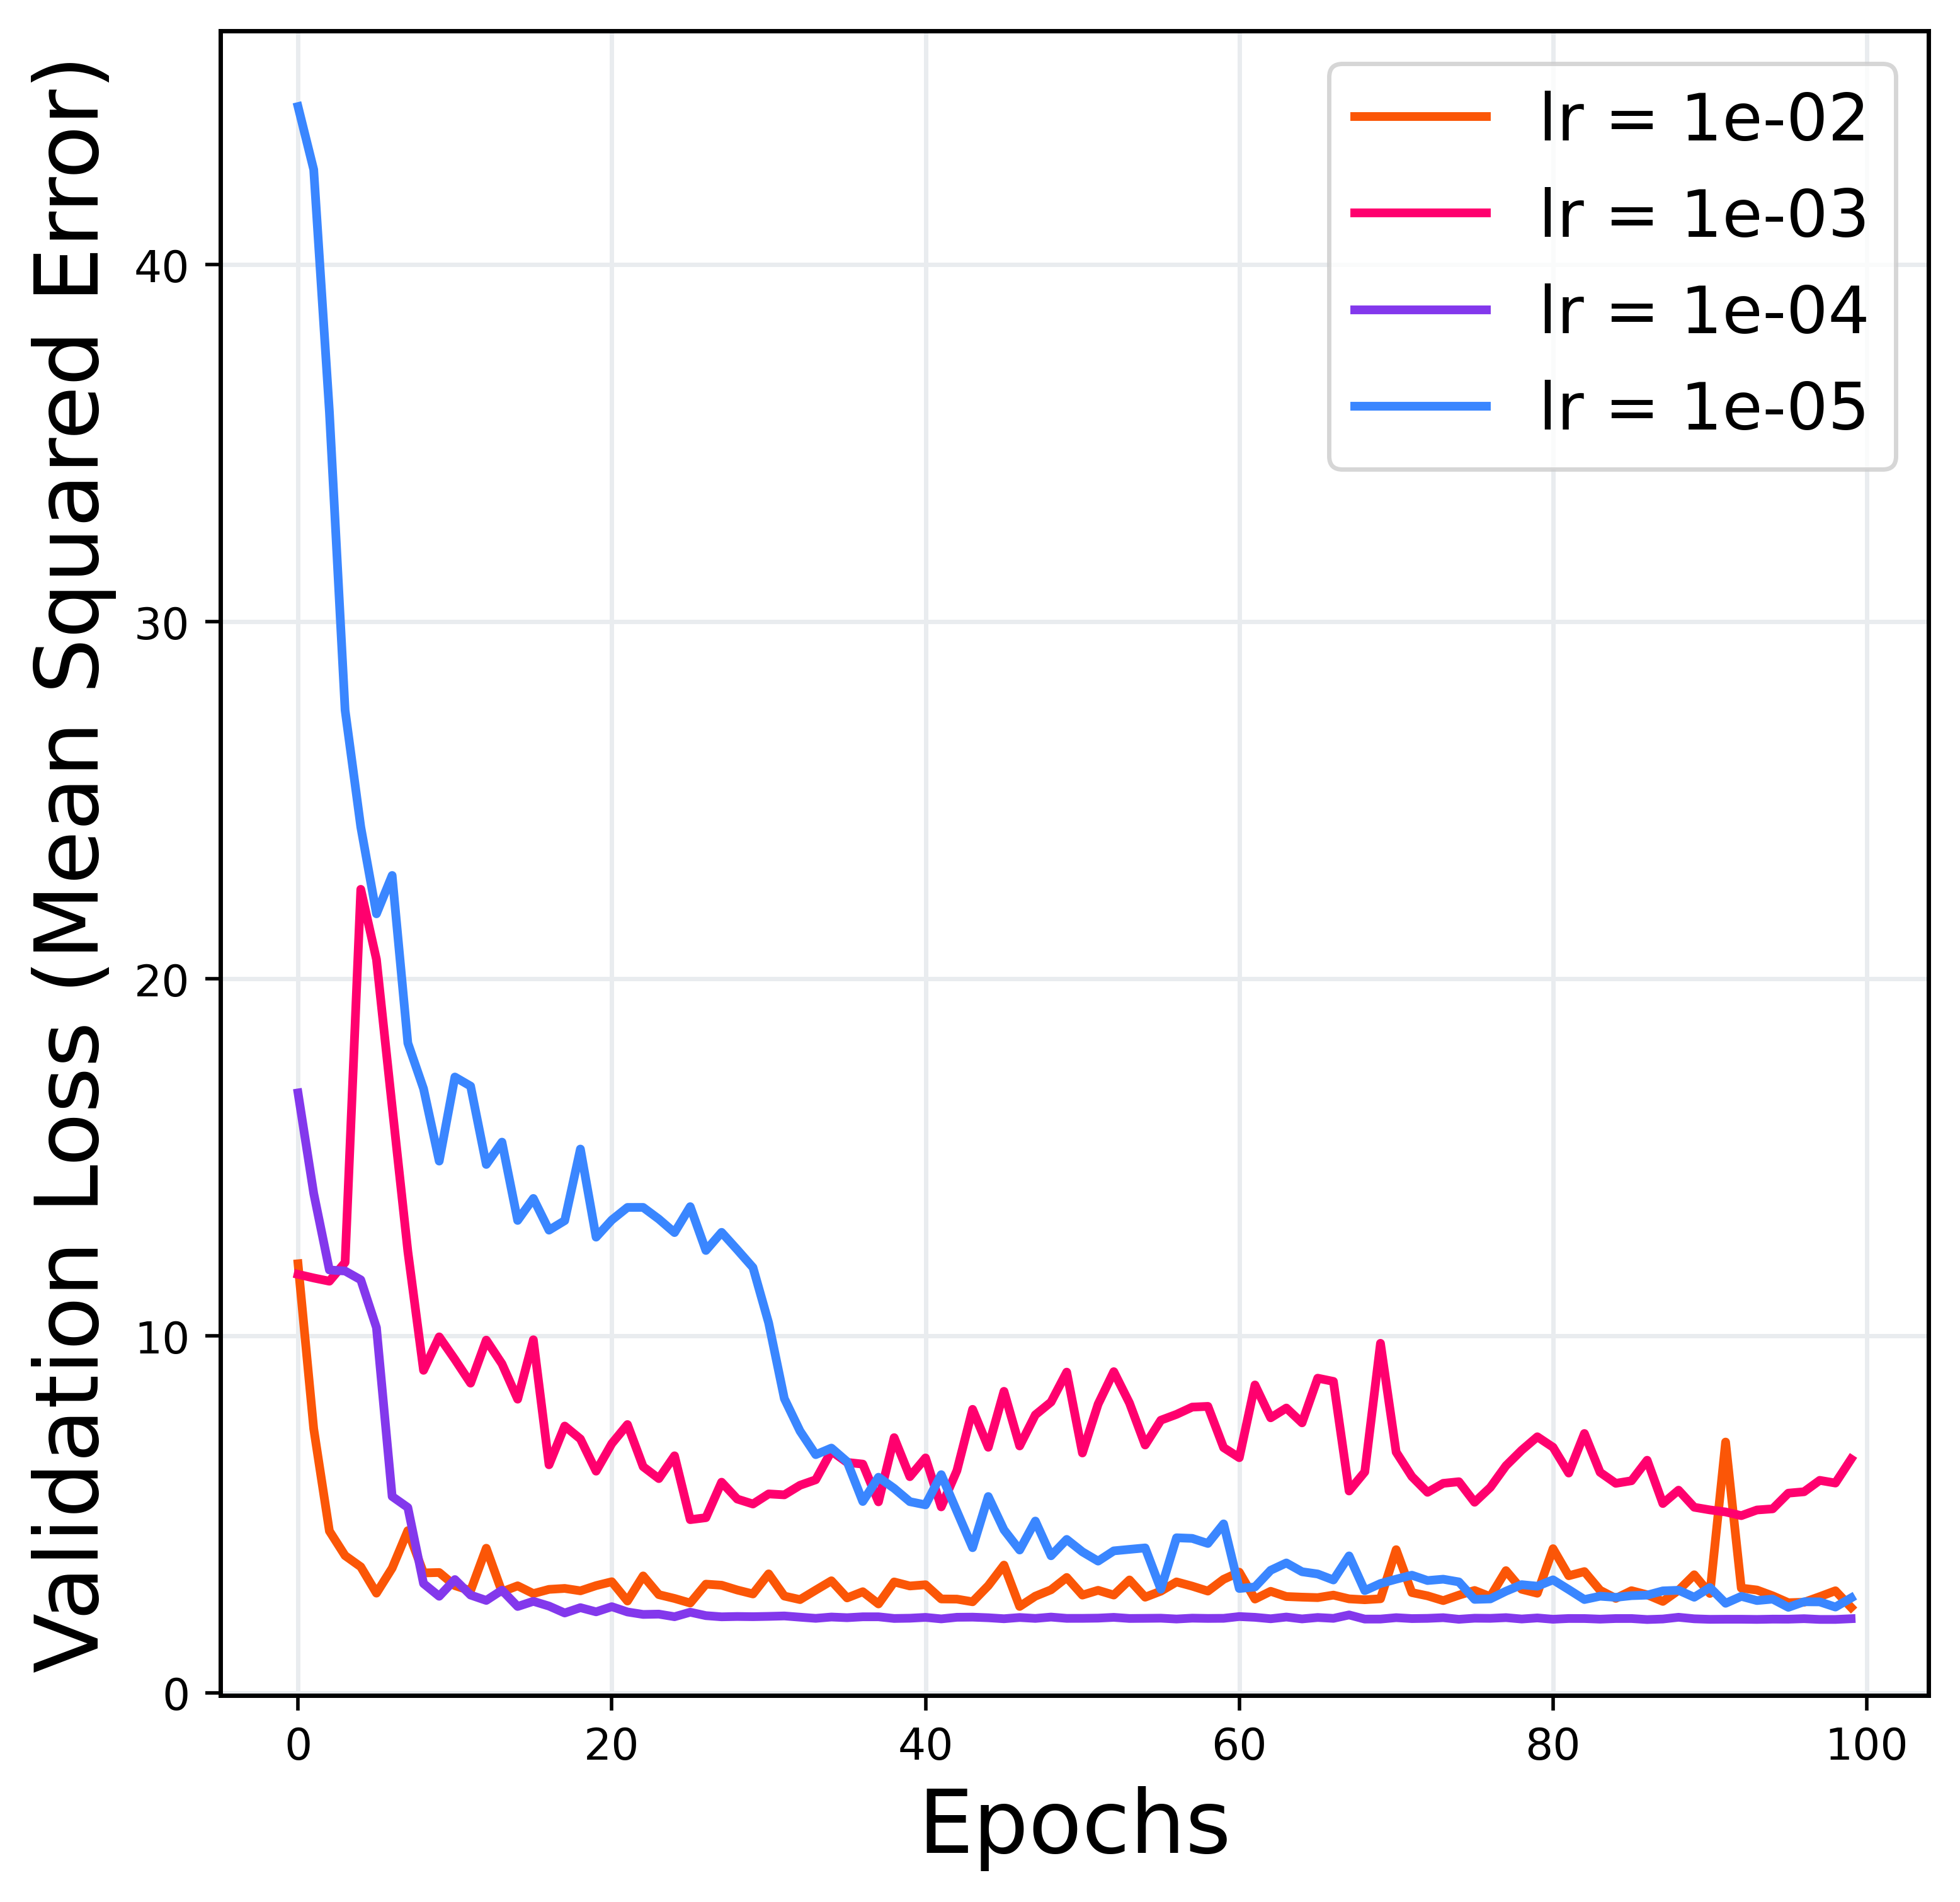

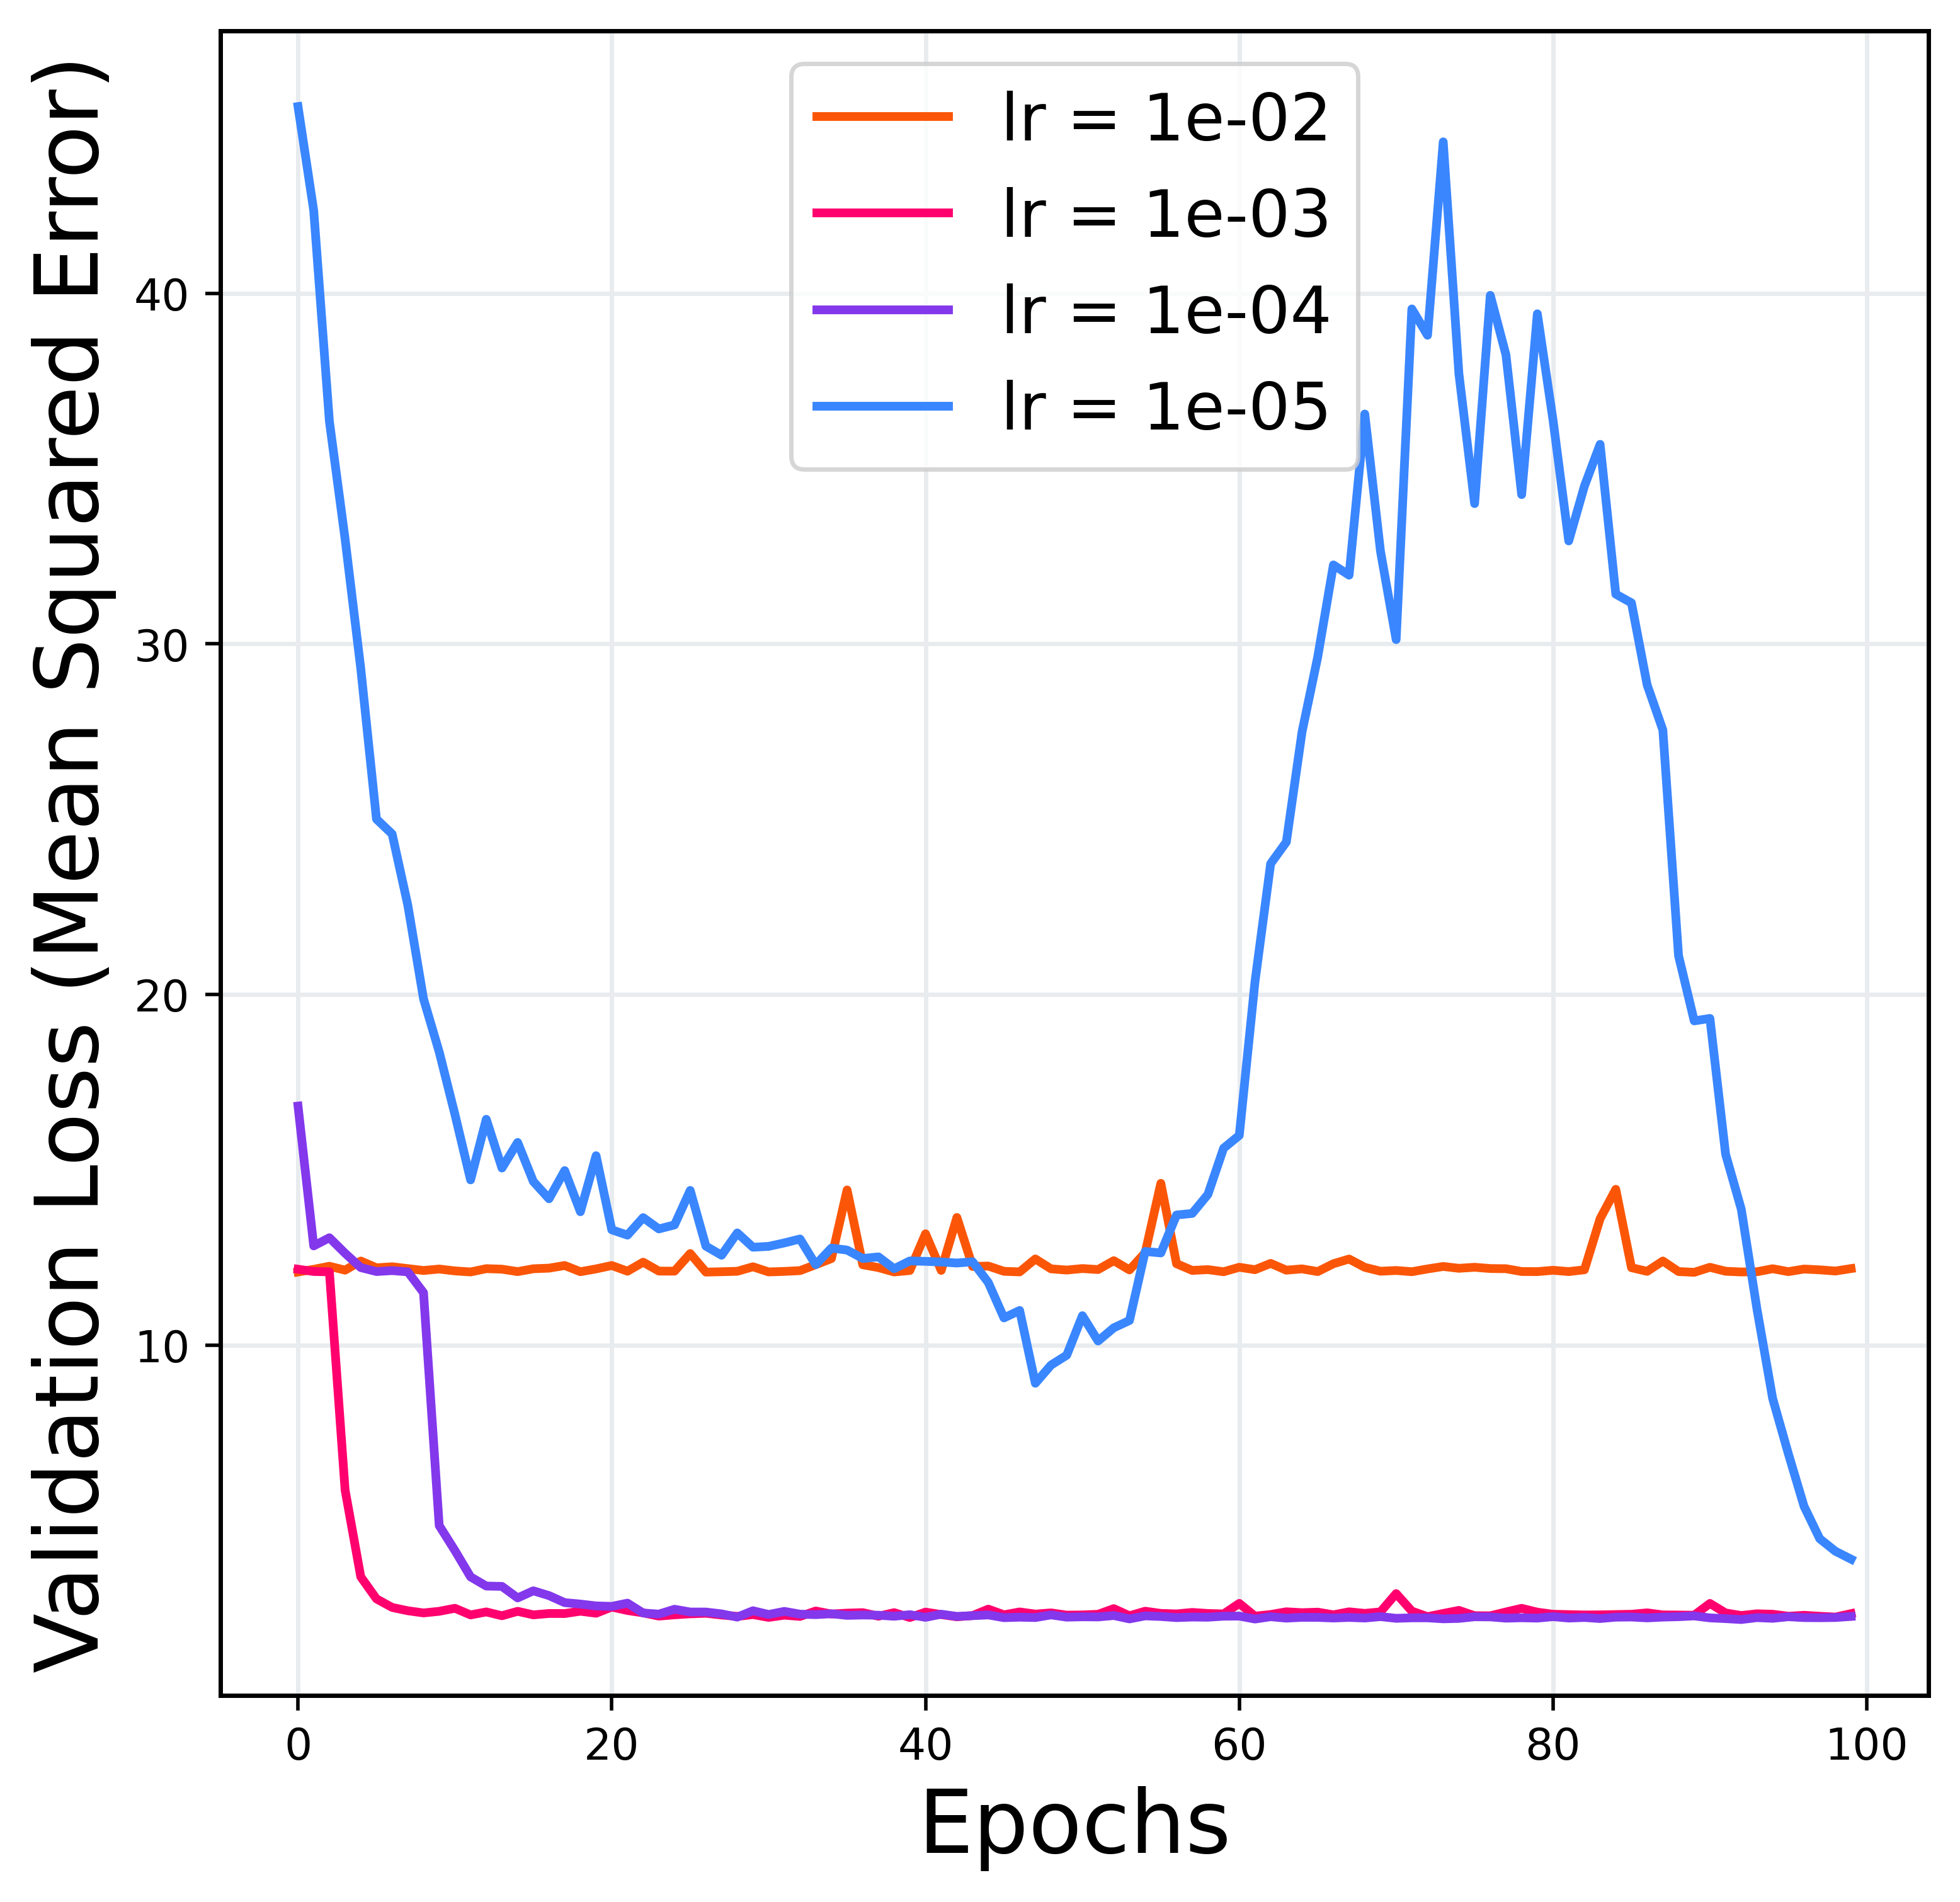

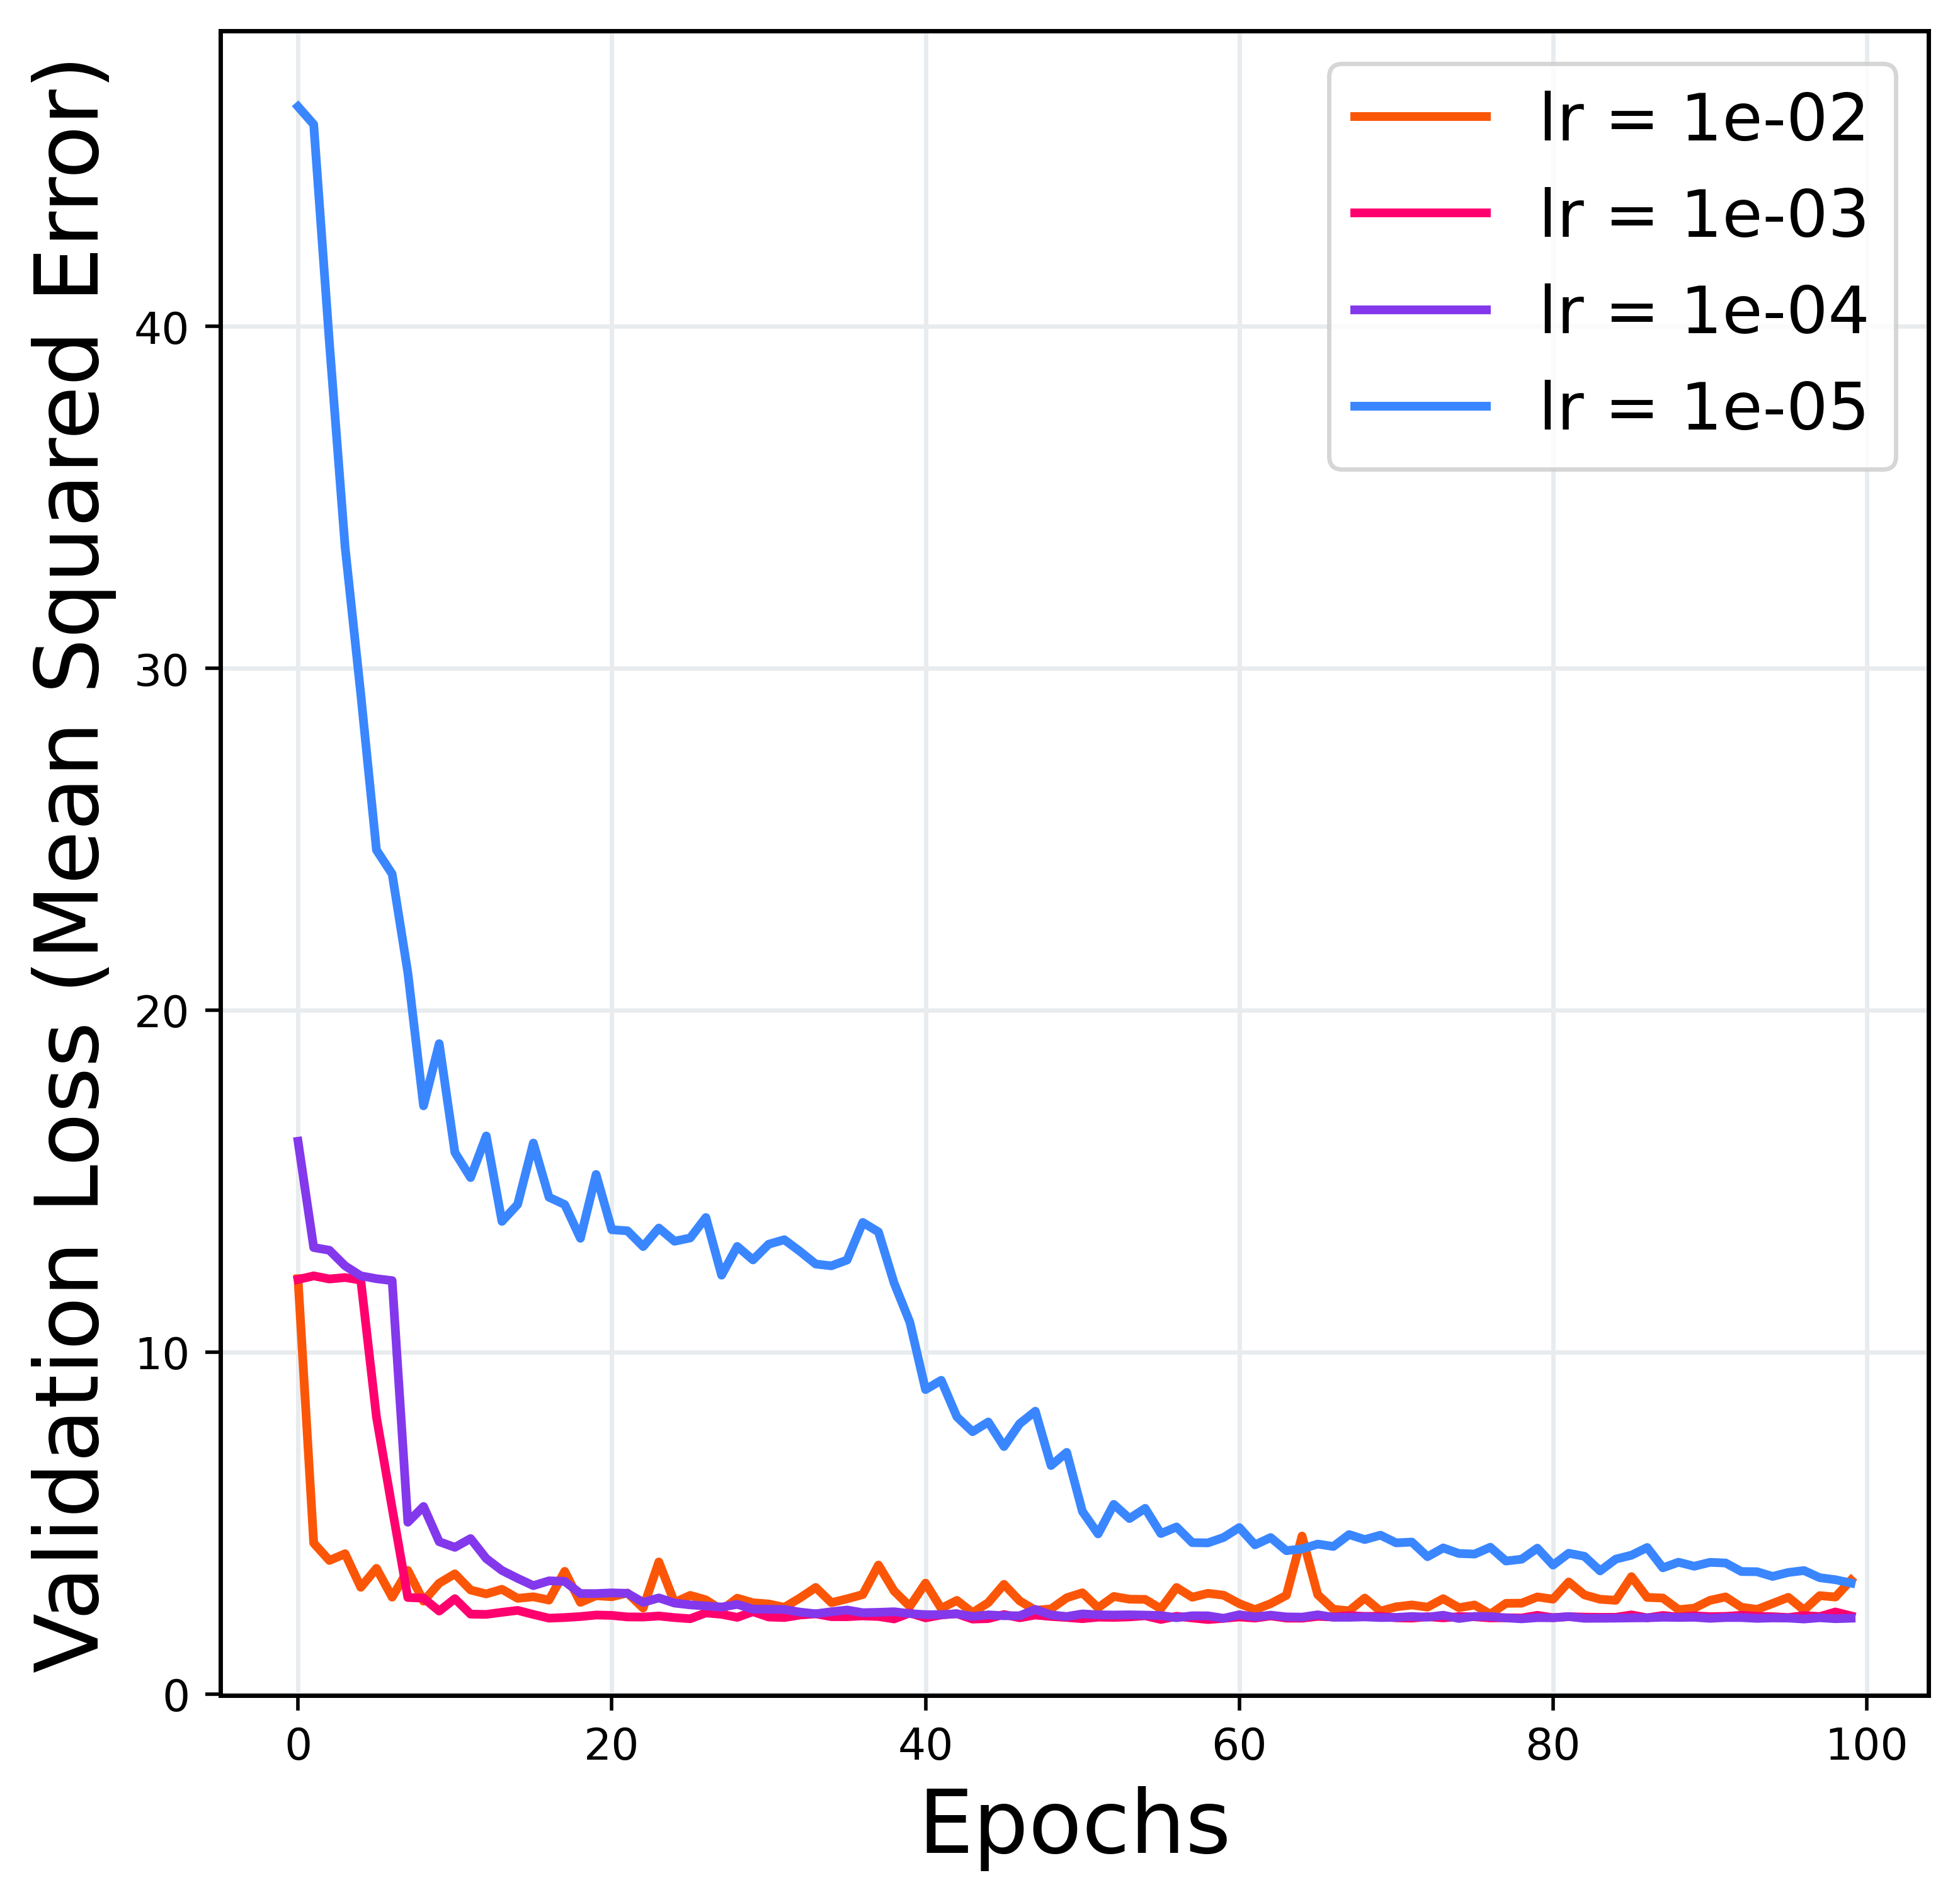

In [ ]:
names = globals()


# model_name = 'rnn'

# GRU: seed 2, lr 4, dropout 0.1
# RNN: seed 4, lr 4, dropout 0.2
# LSTM: seed 4, lr 3, dropout 0.2

def str2list(line_str):
    line_str = line_str.split('\n')[0][1:-1].split(',')
    output = []
    for i in range(len(line_str)):
        output.append(float(line_str[i]))
    return output

def make_train_test_compare(lr, dropout, seed, value, model_name):
    train_nums = {'mse':13,'mae':15,'rmse':17, 'rs': 21, 'train':11}
    # ['mse', 1], ['mae', 3], ['mape', 5], ['rmse', 7], ['rs', 9]
    for seed in range(1, 6):
        file = open(f'/content/drive/MyDrive/ICU/experiments/new_results/{model_name}_lr{lr}_dropout{dropout}_seed{seed}.txt', 'r')
        lines = file.readlines()

        for i in range(len(lines)):
            if i == 9:
                names[f'test_{value}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'] = str2list(lines[i])
                # print(model_name)
                # print(lr)
                # print(dropout)
                # print(seed)
            # elif i == train_nums[value]:
            #     names[f'test_{value}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'] = str2list(lines[i])
            else:
                continue

def make_lr(model_name, dropout, seed, value):
    for lr in range(2, 6):
        file = open(f'/content/drive/MyDrive/ICU/experiments/msnet_result/{model_name}_lr{lr}_dropout{dropout}_seed{seed}.txt', 'r')
        lines = file.readlines()
        for i in range(len(lines)):
            if i == 13:
                names[f'test_{value}_{model_name}_lr{lr}_dropout{dropout}_seed{seed}'] = str2list(lines[i])
            continue

def make_optim(model_name, dropout, seed, lr):
    optim_list = ['Adam', 'SGD', 'Adagrad', 'AdamW', 'Adadelta']

    for optim in optim_list:
        file = open(f'/content/drive/MyDrive/ICU/experiments/new_results/{model_name}_{optim}_lr{lr}_dropout{dropout}_seed{seed}.txt', 'r')
        lines = file.readlines()
        for i in range(len(lines)):
            if i == 1:
                names[f'test_mse_{model_name}_lr{lr}_dropout{dropout}_seed{seed}_{optim}'] = str2list(lines[i])
            continue

def lr_experiment():
    best_params_dict = {
        'gru':[4, 0.1, 1],
        'rnn':[4, 0.2, 4],
        'lstm':[3, 0.2, 4]
    }

    for mode in ['gru', 'rnn', 'lstm']:
        make_lr(mode, best_params_dict[mode][1], best_params_dict[mode][2], 'mse')
        plot_lr(mode, best_params_dict[mode][1], best_params_dict[mode][2])

def performance_experiment():
    best_params_dict = {
        'gru':[4, 0.1],
        'rnn':[4, 0.2],
        'lstm':[3, 0.2]
    }
    for mode in ['gru', 'rnn', 'lstm']:
        lr = best_params_dict[mode][0]
        dropout = best_params_dict[mode][1]
        print(mode)
        for seed in range(1, 6):
            make_train_test_compare(lr, dropout, seed, 'rs', mode)
            # print(names[f'test_mse_{mode}_lr{lr}_dropout{dropout}_seed{seed}'][-1])
            # print(f'Learning rate: {lr}')
            # print(f'Dropout: {dropout}')
        # plot_randomseed(mode, lr, dropout)
    plot_r2()

def optim_experiment():
    lr = 4
    dropout = 0.1
    seed = 1
    for optim in ['adam', 'SGD', 'Adagrad', 'AdamW', 'Adadelta']:
        make_optim('gru', dropout, seed, lr)
        plot_optim('gru', dropout, seed, lr)

lr_experiment()


In [ ]:
names[f'test_rs_lstm_lr3_dropout0.2_seed3']

KeyError: ignored

In [ ]:
names = globals()

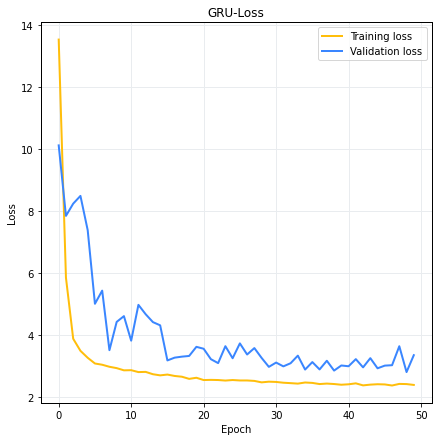

In [ ]:
plt.figure(figsize=(7,7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU-Loss')

_alpha = 1
_width = 2

ax = plt.gca()
ax.set_facecolor('white')
ax.patch.set_alpha(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
plt.plot(training_losses, label='Training loss', color='#ffbe0b', alpha=_alpha, linewidth = _width)
plt.plot(testing_losses, label='Validation loss', color='#3a86ff', alpha=_alpha, linewidth = _width)
plt.legend()
plt.show()

In [ ]:
reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/ICU/Keras_models/my_model_0_24")

# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# reconstructed_model.fit(test_input, test_target)

In [ ]:
x_train, y_train = MyData(data, 24)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

predicted_sofa = reconstructed_model.predict(x_test)       

In [ ]:
predicted_sofa = reconstructed_model.predict(x_test)

In [ ]:
import math

def plot_gallery(images, titles=None, xscale=1, yscale=1, nrow=3, cmap='rainbow', output=None):
    ncol = math.ceil(len(images) / nrow)
    
    plt.figure(figsize=(xscale * ncol, yscale * nrow))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        if i < len(images):
            plt.imshow(images[i], cmap=cmap)
            if titles is not None:
                # use size and y to adjust font size and position of title
                plt.title(titles[i], size=12, y=1)
        plt.xticks(())
        plt.yticks(())

    plt.tight_layout()

    if output is not None:
        plt.savefig(output)
    plt.show()

In [ ]:
avg_total = {}
predicted_sofa = reconstructed_model.predict(x_test)
for i in range(len(y_test)):
    avg_ = []
    for j in range(24):
        avg_value = abs(predicted_sofa[i][j] - y_test[i][j])
        avg_.append(avg_value)
    avg_total[i] = np.mean(avg_)

In [ ]:
best_ = sorted(avg_total.items(), key=lambda x: x[1], reverse=False)
best_[:10]

[(2314, 0.12087572614351909),
 (4181, 0.14113202691078186),
 (4239, 0.17014798521995544),
 (3258, 0.17558181285858154),
 (3789, 0.17637337247530618),
 (4226, 0.18783193826675415),
 (2764, 0.19230767091115317),
 (629, 0.19477244218190512),
 (2358, 0.19766976435979208),
 (1472, 0.20049741367499033)]

In [ ]:
best_list = []
for i in range(10):
    best_list.append(best_[:10][i][0])
best_list

[2314, 4181, 4239, 3258, 3789, 4226, 2764, 629, 2358, 1472]

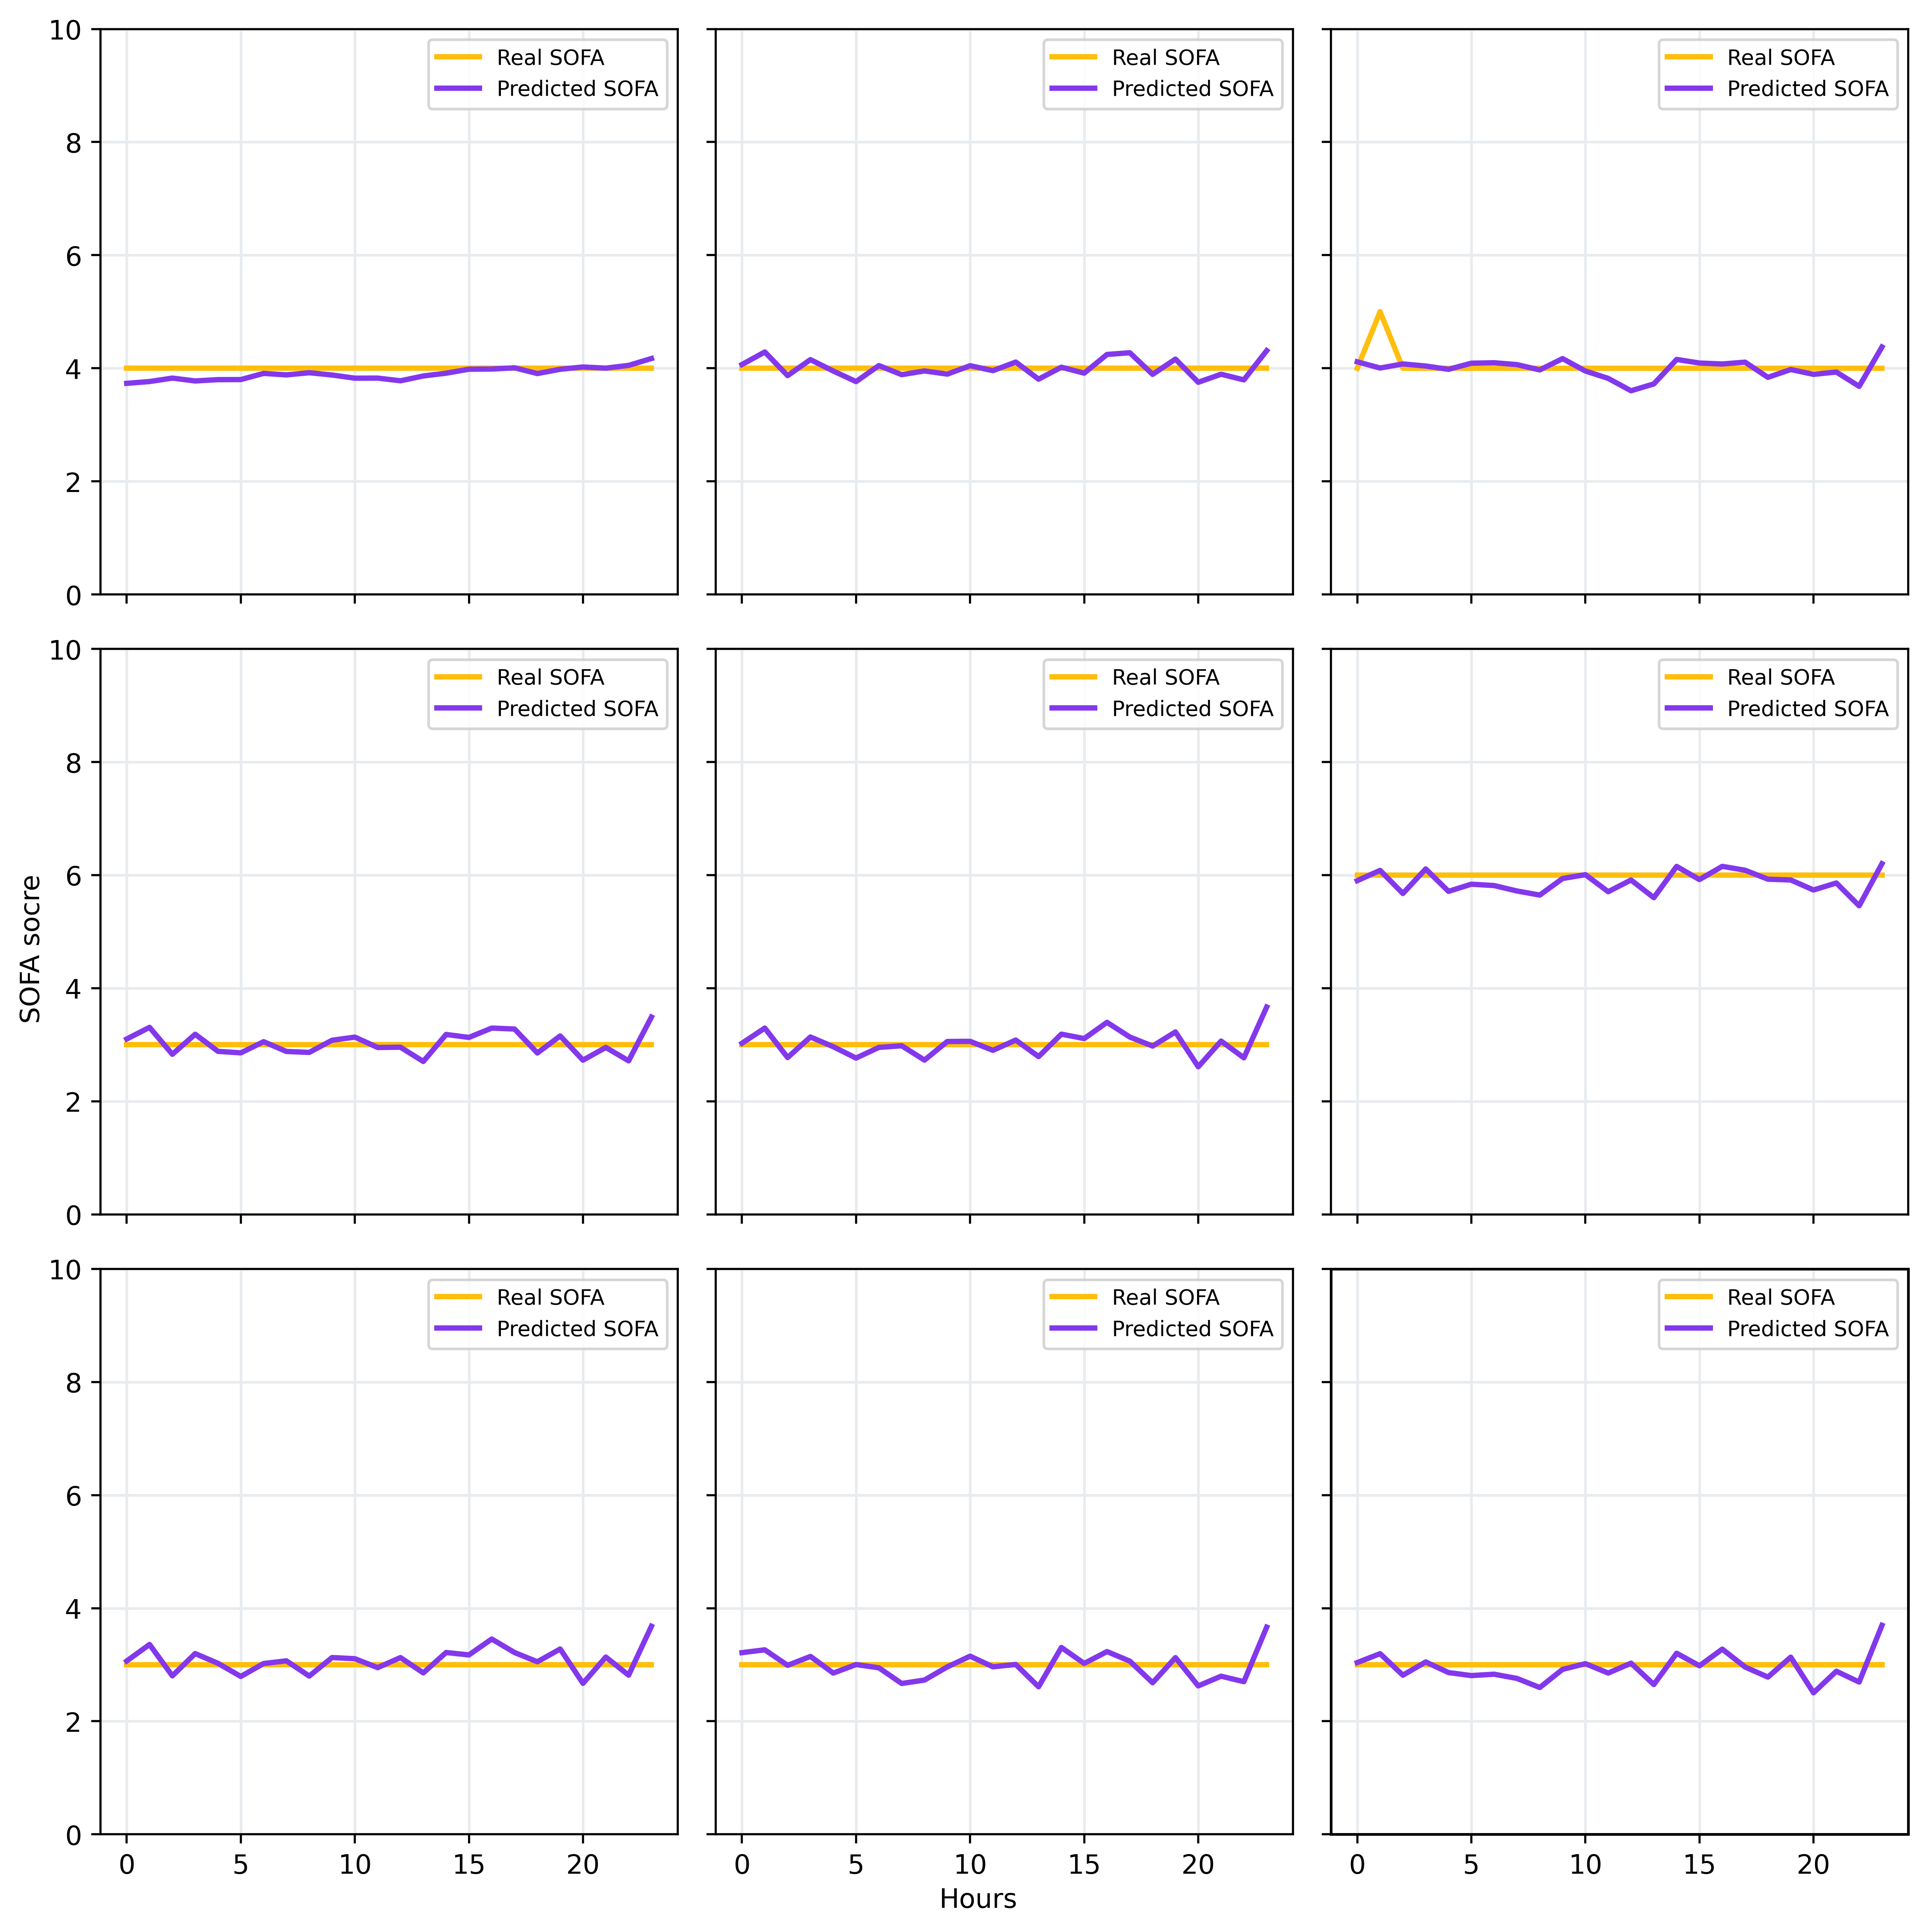

In [ ]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10), dpi=500)
_alpha = 1
_width = 2

ax = plt.gca()
ax.set_facecolor('white')
ax.patch.set_alpha(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

for i, row in enumerate(axes):
    for j, col in enumerate(row):
        plt.ylim((0, 10))
        col.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
        col.plot(y_test[best_list[i * 3 + j]], label='Real SOFA', color='#ffbe0b', alpha=_alpha, linewidth = _width)
        col.plot(predicted_sofa[best_list[i * 3 + j]], label='Predicted SOFA', color='#8338ec', alpha=_alpha, linewidth = _width)
        col.legend(fontsize = 8)
        
fig.text(0.5, 0, 'Hours', ha='center')
fig.text(0, 0.5, 'SOFA socre', va='center', rotation='vertical')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

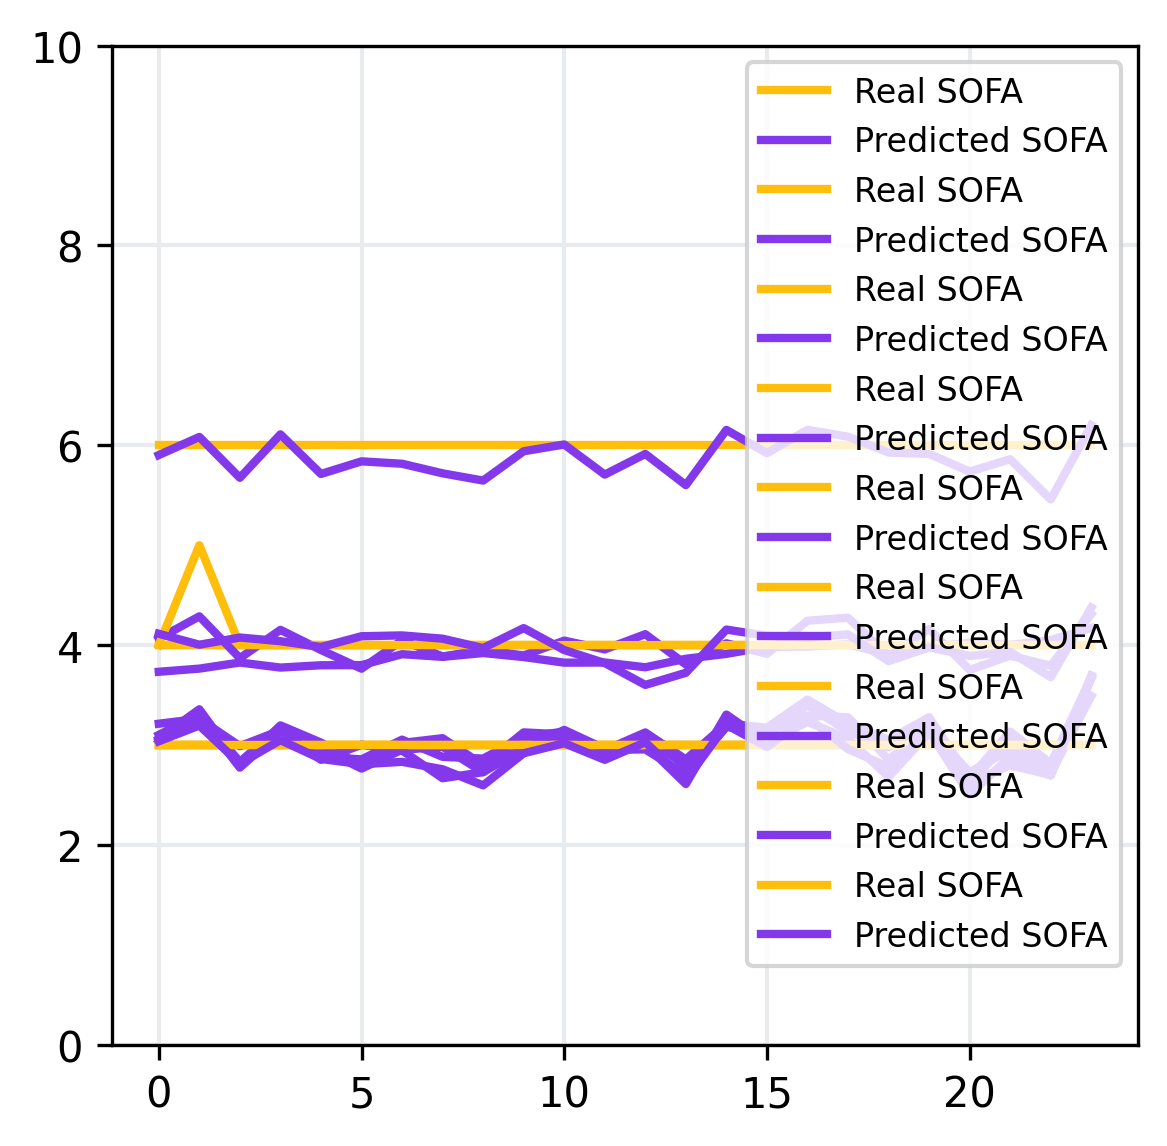

In [ ]:
plt.figure(figsize=(15,15), dpi=300)
_alpha = 1
_width = 2

ax = plt.gca()
ax.set_facecolor('white')
ax.patch.set_alpha(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

n = 0
for i in best_list:
    plt.ylim((0, 10))
    plt.subplot(3, 3, n+1)
    plt.grid(color = '#e9ecef', which='both', linestyle = '-', linewidth = 1)
    plt.plot(y_test[i], label='Real SOFA', color='#ffbe0b', alpha=_alpha, linewidth = _width)
    plt.plot(predicted_sofa[i], label='Predicted SOFA', color='#8338ec', alpha=_alpha, linewidth = _width)
    plt.legend(fontsize = 8)
plt.show()